### Install (if needed) all prereqs below

In [18]:
#!pip install requests
#!pip install openai
#!pip install dotenv

### GPT Configs & Pre-reqs

GPT4-Vision: 
- Get the GPT4V key and the endpoint in Azure AI Studio and replace the values in env.env file

In [28]:
import requests
import base64
import json
from openai import AzureOpenAI
from dotenv import dotenv_values
from mimetypes import guess_type

# Create the env file based on the template.env provided. Put all key values, endpoints, etc. according to the template
env_name = "env.env" 
config = dotenv_values(env_name)

# Use your own keys in env.env file for openai_api_key_vision and openai_completion_endpoint_vision parameters

GPT4V_KEY = config['openai_api_key_4t']
GPT4V_ENDPOINT = config['openai_chat_endpoint_4t']

# Provide the image path
IMAGE_PATH = "images\purchase-order-example.jpg"

### Python code to convert the image that will be used to base64 so it can be passed to the API

Data URL: 

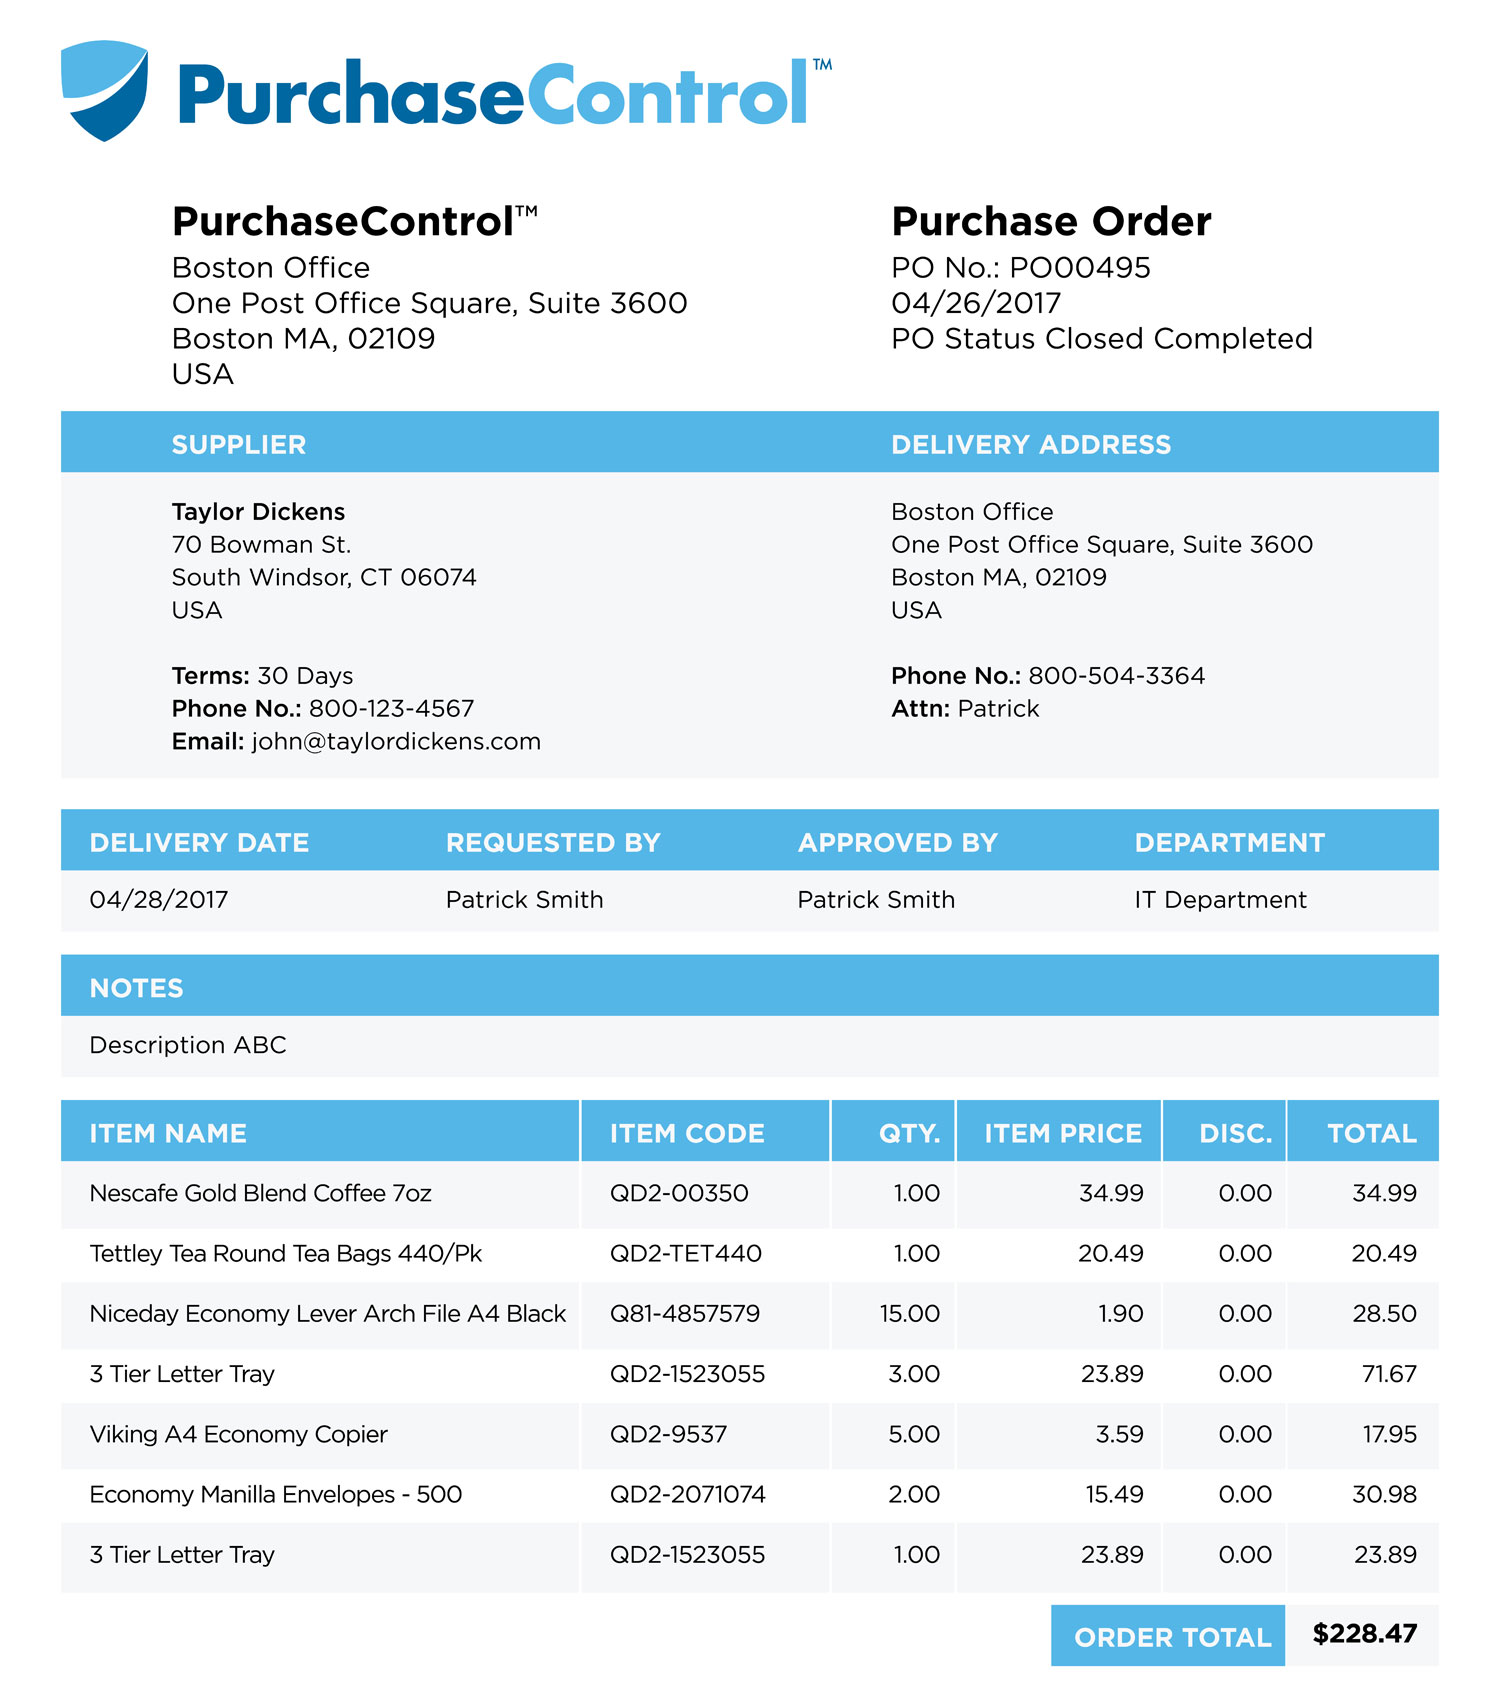

In [29]:
# Function to encode a local image into data URL 
def local_image_to_data_url(image_path):
    # Guess the MIME type of the image based on the file extension
    mime_type, _ = guess_type(image_path)
    if mime_type is None:
        mime_type = 'application/octet-stream'  # Default MIME type if none is found

    # Read and encode the image file
    with open(image_path, "rb") as image_file:
        base64_encoded_data = base64.b64encode(image_file.read()).decode('utf-8')

    # Construct the data URL
    return f"data:{mime_type};base64,{base64_encoded_data}"

# Example usage
image_path = 'images\purchase-order-example.jpg'
data_url = local_image_to_data_url(image_path)
print("Data URL:", data_url)

### Definition of the prompt that you will use in order to extract the required information

In [31]:
# Change the prompt according to the PO layout you want to extract
base_prompt = '''

You are an AI assistant that helps extract information from purchase orders.

Extract the Purchase Order number, PO Status, the Supplier name and address, Customer Name and Address, the delivery date, order total and all items in the table.

Output the information in JSON format in the following structure:

{
 purchase_order:
 purchase_order_status:
 customer_name:
 customer_address:
 supplier_name:
 supplier_address:
 delivery_date:
 order_total:
 table:
[
 {
  item_name:
  item_code:
  quantity:
  item_price:
 discount:
 total:

 }
]
}

'''

### Call the Chat Completion APIs

In [32]:

encoded_image = base64.b64encode(open(IMAGE_PATH, 'rb').read()).decode('ascii')
headers = {
    "Content-Type": "application/json",
    "api-key": GPT4V_KEY,
}

# Payload for the request
payload = {
  "messages": [
    {
      "role": "system",
      "content": [
        {
          "type": "text",
          "text": "You are an AI assistant that extract information from an image that contains purchase order information. Output only plain text. Do not output markdown"
        }
      ]
    },
    {
      "role": "user",
      "content": [
        {
          "type": "image_url",
          "image_url": {
            "url": f"data:image/jpeg;base64,{encoded_image}"
          }
        },
        {
          "type": "text",
          "text": base_prompt
        }
      ]
    }
  ],
  "temperature": 0,
  "top_p": 0.95,
  "max_tokens": 4096
}


# Send request
try:
    response = requests.post(GPT4V_ENDPOINT, headers=headers, json=payload)
    response.raise_for_status()  # Will raise an HTTPError if the HTTP request returned an unsuccessful status code
except requests.RequestException as e:
    raise SystemExit(f"Failed to make the request. Error: {e}")


result = response.json()


### Now you have the results in JSON format and you can integrate it with any other service to continue with your automation

##### Try changing the prompts or instruction to process more fields such as Department, notes, etc.

In [35]:
result = response.json()

return_value = result["choices"][0]["message"]["content"]

print(return_value)


{
  "purchase_order": "P000495",
  "purchase_order_status": "Closed Completed",
  "customer_name": "Boston Office",
  "customer_address": "One Post Office Square, Suite 3600, Boston MA, 02109, USA",
  "supplier_name": "Taylor Dickens",
  "supplier_address": "70 Bowman St., South Windsor, CT 06074, USA",
  "delivery_date": "04/28/2017",
  "order_total": "$228.47",
  "table": [
    {
      "item_name": "Nescafe Gold Blend Coffee 7oz",
      "item_code": "QD2-00350",
      "quantity": "1.00",
      "item_price": "34.99",
      "discount": "0.00",
      "total": "34.99"
    },
    {
      "item_name": "Tetley Tea Round Tea Bags 440/Pk",
      "item_code": "QD2-TET440",
      "quantity": "1.00",
      "item_price": "20.49",
      "discount": "0.00",
      "total": "20.49"
    },
    {
      "item_name": "Niceday Economy Lever Arch File A4 Black",
      "item_code": "G81-4857579",
      "quantity": "15.00",
      "item_price": "1.90",
      "discount": "0.00",
      "total": "28.50"
    },
 